# Sentiment analysis convnets

This notebook is based on the code samples found in Chapter 6, Section 4 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff) and Jon Krohn's Deep Learning for Natural Language Processing LiveLessons. 


## Implementing a 1D convnet

In Keras, you would use a 1D convnet via the `Conv1D` layer, which has a very similar interface to `Conv2D`. It takes as input 3D tensors 
with shape `(samples, time, features)` and also returns similarly-shaped 3D tensors. The convolution window is a 1D window on the temporal 
axis, axis 1 in the input tensor.

Let's build a simple 2-layer 1D convnet and apply it to the IMDB sentiment classification task that you are already familiar with.

As a reminder, this is the code for obtaining and preprocessing the data:

#### Load dependencies

In [1]:
import keras
import random
keras.__version__

from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from keras.callbacks import ModelCheckpoint

import os

from sklearn.metrics import roc_auc_score 

import matplotlib.pyplot as plt 
%matplotlib inline

Using TensorFlow backend.


#### Directory to store check point files during training

In [2]:
# output directory name:
output_dir = 'model_output/conv'

#### Load data

In [23]:
n_unique_words = 10000 
print('Loading data...')
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words) # removed n_words_to_skip
print(len(x_train), 'training sequences')
print(len(x_valid), 'validation sequences')

Loading data...
(25000, 'training sequences')
(25000, 'validation sequences')


#### Preprocess data

In [35]:
max_review_length = 500
pad_type = trunc_type = 'pre'
x_train = random.sample(x_train, 10000)
y_train = random.sample(y_train, 10000)
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
print('x_train shape:', x_train.shape)
print('x_valid shape:', x_valid.shape)

('x_train shape:', (10000, 500))
('x_valid shape:', (25000, 500))


#### Design neural network architecture
1D convnets are structured in the same way as their 2D counter-parts that you have used in Chapter 5 in [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff): they consist of a stack of `Conv1D` 
and `MaxPooling1D` layers, eventually ending in either a global pooling layer or a `Flatten` layer, turning the 3D outputs into 2D outputs, 
allowing to add one or more `Dense` layers to the model, for classification or regression.

One difference, though, is the fact that we can afford to use larger convolution windows with 1D convnets. Indeed, with a 2D convolution 
layer, a 3x3 convolution window contains 3*3 = 9 feature vectors, but with a 1D convolution layer, a convolution window of size 3 would 
only contain 3 feature vectors. We can thus easily afford 1D convolution windows of size 7 or 9.

##### Baseline model and hyperparameters from François Chollet
Try this one or the model from Jon Krohn below. Note that the last one you run before you compile will be the one that you use for training so if you want to use Jon's model, make sure to step past the model below.

In [31]:
epochs = 10
batch_size = 128

model = Sequential()
model.add(layers.Embedding(n_unique_words, 128, input_length=max_review_length))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
_________________________________________________________________


#### Baseline model and hyperparameters from François Chollet

In [27]:
# training:
epochs = 4
batch_size = 128

# vector-space embedding: 
n_dim = 64

drop_embed = 0.2

# convolutional layer architecture:
n_conv = 256 # filters, a.k.a. kernels
k_conv = 3 # kernel length

# dense layer architecture: 
n_dense = 256
dropout = 0.2

model = Sequential()
model.add(layers.Embedding(n_unique_words, n_dim, input_length=max_review_length)) 
model.add(layers.SpatialDropout1D(drop_embed))
model.add(layers.Conv1D(n_conv, k_conv, activation='relu'))
# model.add(layers.Conv1D(n_conv, k_conv, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(n_dense, activation='relu'))
model.add(layers.Dropout(dropout))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 500, 64)           640000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 500, 64)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 498, 256)          49408     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total para

#### Compile the model

In [33]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#### Configure to store check points

In [34]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir + "/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Train the model
We store the history of the optimization so that we can plot it later

This will take from tens of seconds to minutes per epoch on a laptop depending on hyper parameters and model structure.

Note how at the end of each epoch things come to a halt. This is then the model is evaluated on the validation data.

In [36]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Train on 10000 samples, validate on 25000 samples
Epoch 1/10
10000/10000 [==============================] - 31s 3ms/step - loss: 0.6690 - acc: 0.5825 - val_loss: 0.5344 - val_acc: 0.7842
Epoch 2/10
10000/10000 [==============================] - 30s 3ms/step - loss: 0.3537 - acc: 0.8531 - val_loss: 0.3486 - val_acc: 0.8472
Epoch 3/10
10000/10000 [==============================] - 30s 3ms/step - loss: 0.1624 - acc: 0.9440 - val_loss: 0.3886 - val_acc: 0.8454
Epoch 4/10
10000/10000 [==============================] - 30s 3ms/step - loss: 0.0707 - acc: 0.9807 - val_loss: 0.4650 - val_acc: 0.8428
Epoch 5/10
10000/10000 [==============================] - 31s 3ms/step - loss: 0.0243 - acc: 0.9964 - val_loss: 0.5529 - val_acc: 0.8413
Epoch 6/10
10000/10000 [==============================] - 32s 3ms/step - loss: 0.0081 - acc: 0.9997 - val_loss: 0.6225 - val_acc: 0.8395
Epoch 7/10
10000/10000 [==============================] - 32s 3ms/step - loss: 0.0034 - acc: 0.9999 - val_loss: 0.6667 - val_acc

#### Display training progress

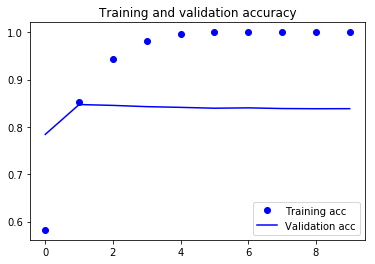

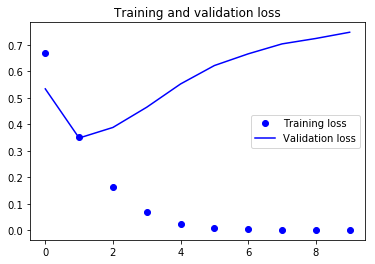

In [37]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### Load the best model parameters
To do this, look at the training above and pick out the epoch that you consider to be the best. You could also attempt to identify this automatically from the history. Assuming that epoch 1 had the best results, you would load::

    model.load_weights(output_dir+"/weights.01.hdf5") # zero-indexed

In [38]:
model.load_weights(output_dir + "/weights.01.hdf5") # zero-indexed

#### Calculate the area under the curve for the ROC curve to get a scalar value to express the performance of the network
This code only runs if you ensure that the output is a probability like you would get with a sigmoid (see Jon's model)

In [39]:
y_hat = model.predict_proba(x_valid)
"{:0.2f}".format(roc_auc_score(y_valid, y_hat)*100.0)

'86.88'

#### Visualize the output of the classifier

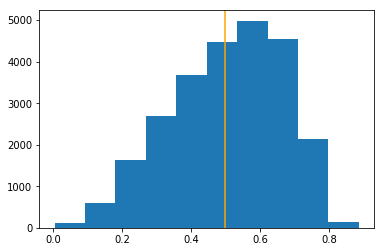

In [40]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

## 1D and 2D convnets

* In the same way that 2D convnets perform well for processing visual patterns in 2D space, 1D convnets perform well for processing temporal patterns. 
* Typically 1D convnets are structured much like their 2D equivalents from the world of computer vision: they consist of stacks of `Conv1D` layers and `MaxPooling1D` layers, eventually ending in a global pooling operation or flattening operation.